# Preprocessing
Parse and clean fMRI data before running searchlight analysis

In [77]:
# Import dependencies
import numpy as np
import nibabel as nib # load nifti files
import glob # load files from a directory
from nilearn import image, plotting
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score


In [78]:
# define paths
import os

data_path = "../data"
results_path = "../results"

In [79]:
def load_data(data_path):
    """
    Load all fMRI data from the data directory
    """
    # Check if the data path exists
    if not os.path.exists(data_path):
        raise ValueError("Data path does not exist")
    
    dataset = []
    data_path = os.path.join(data_path, '')
    pattern = os.path.join(data_path, 'sub-*/func/*.nii.gz')
    files = glob.glob(pattern)

    # Check if the file exists
    if not files:
        raise FileNotFoundError("No files found in the {pattern}")
    
    for file in files:
        try:
            img = nib.load(file)
            dataset.append(img)
            print(f"Successfully loaded: {file}")
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue
    
    if not dataset:
        raise ValueError("No valid NIfTI files found in the {pattern}")
        
    return dataset

# load datasets
data_path_audio = "../data/audio"
data_path_visual = "../data/visual"

dataset_audio = load_data(data_path_audio)
dataset_visual = load_data(data_path_visual)

print(len(dataset_audio)) 
print(dataset_audio[0])

print(len(dataset_visual))
print(dataset_visual[0])



Successfully loaded: ../data/audio/sub-01/func/sub-01_task-auditory_run-03_bold.nii.gz
Successfully loaded: ../data/audio/sub-01/func/sub-01_task-auditory_run-06_bold.nii.gz
Successfully loaded: ../data/audio/sub-01/func/sub-01_task-auditory_run-05_bold.nii.gz
Successfully loaded: ../data/audio/sub-01/func/sub-01_task-auditory_run-02_bold.nii.gz
Successfully loaded: ../data/audio/sub-01/func/sub-01_task-auditory_run-08_bold.nii.gz
Successfully loaded: ../data/audio/sub-01/func/sub-01_task-auditory_run-01_bold.nii.gz
Successfully loaded: ../data/audio/sub-01/func/sub-01_task-auditory_run-04_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Conj9Inh_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Feat9Inh_acq-b_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Feat19Sel_acq-b_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Conj19Sel_acq-a_bold.nii.gz
Successfully loaded: ../data/visu

In [85]:
# Visualize the data
import matplotlib.pyplot as plt
def visualize_data(data):
    """
    Visualize the data using nilearn's plotting functions
    """
    # Extract the data array and affine matrix from the nifti object
    data_array = data.get_fdata()
    affine = data.affine

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    x, y, z, t = data_array.shape
    middle_x = x // 2 # get the middle slice in the x direction
    middle_y = y // 2
    middle_z = z // 2
    middle_t = t // 2

    # Plot views at a middle timepoint
    axes[0, 0].imshow(data_array[middle_x, :, :, middle_t])
    axes[0, 0].set_title('Sagittal View')

    axes[0, 1].imshow(data_array[:, middle_y, :, middle_t])
    axes[0, 1].set_title('Coronal View')

    axes[1, 0].imshow(data_array[:, :, middle_z, middle_t])
    axes[1, 0].set_title('Axial View')

    axes[1, 1].imshow(data_array[:, :, middle_z, middle_t])
    axes[1, 1].set_title('Time Series')

    plt.tight_layout()
    plt.show()

    return data_array

visualize_data(load_data(data_path)[0])

FileNotFoundError: No files found in the {pattern}

Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Conj9Inh_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Feat9Inh_acq-b_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Feat19Sel_acq-b_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Conj19Sel_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Feat1Inh_acq-b_bold.nii.gz
Successfully loaded: ../data/visual/sub-213/func/sub-213_task-Conj1Inh_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-214/func/sub-214_task-Conj1Inh_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-214/func/sub-214_task-Conj19Sel_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-214/func/sub-214_task-Conj9Inh_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-214/func/sub-214_task-Feat9Inh_acq-a_bold.nii.gz
Successfully loaded: ../data/visual/sub-219/func/sub-219_task-Conj1Inh_acq-b_bold.nii.gz
Successfully loade

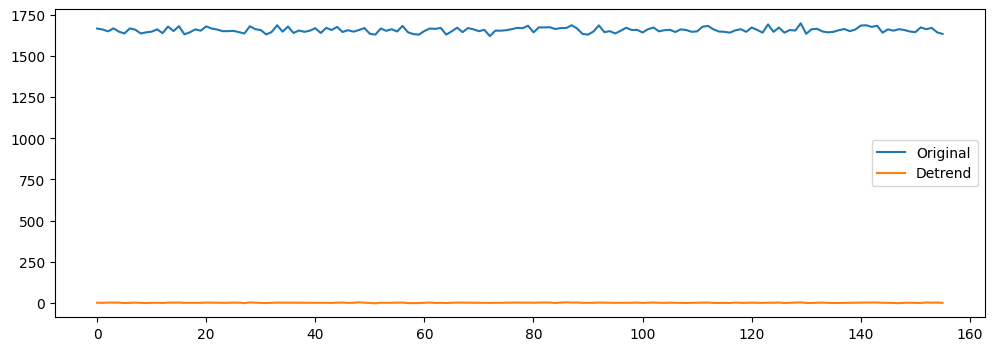

In [53]:
# clean the data
from nilearn import image as nli
from nilearn import plotting

def clean_data(data):
    """
    Clean the data by removing artifacts and normalizing the data
    """
    # resample the data to the template
    mean = nli.mean_img(data)
    resampled_data = nli.resample_to_img(data, mean)

    detrended_data = detrend_data(resampled_data)

    return clean_data

def detrend_data(resampled_data):
    """
    Detrend the data by removing frequency noise
    """
    smoothed_data = nli.smooth_img(resampled_data, fwhm=6)
    TR = resampled_data.header['pixdim'][4] # get the reptition time from the header
    func_d= nli.image.clean_img(smoothed_data, detrend=True, standardize=True, t_r=TR, confounds=None)

    x, y, z, t = func_d.shape
    print(f"Data shape: {x} x {y} x {z} x {t}")

    # Retrieve middle points
    mid_x = x // 2
    mid_y = y //2 
    mid_z = z // 2
    mid_t = t // 2

    # Plot the time series at the middle points
    plt.figure(figsize=(12, 4))
    plt.plot(np.transpose(resampled_data.get_fdata()[mid_x, mid_y, mid_z, :]))
    plt.plot(np.transpose(func_d.get_fdata()[mid_x, mid_y, mid_z, :]))
    plt.legend(['Original', 'Detrend'])
    plt.show()

    return func_d

clean_data = clean_data(load_data(data_path)[0])
